# Multiprocessing Environments
These are useful in cases where you want to parallelize the environment simulation to speed up training.
the folllowing are the benefits of using multiprocessing environments:
1. Agent experience can be collected more quickly.
2. The experience will contain more diverse range of states, improving exploration

In [1]:
import gymnasium as gym
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.evaluation import evaluate_policy

In [7]:
env = gym.make('CartPole-v1')
env.seed(0)

AttributeError: 'TimeLimit' object has no attribute 'seed'

In [36]:
def make_env(env_id, rank, seed=0):
    """
    Utility function for multiprocessed env.

    :param env_id: (str) the environment ID
    :param rank: (int) index of the subprocess
    :param seed: (int) the initial seed for RNG
    """
    def _init():
        env = gym.make(env_id, render_mode=None) # Put 'human' to visualize
        env.reset(seed=seed + rank)
        return env
    set_random_seed(seed)
    return _init

Preview this paper
https://arxiv.org/abs/1709.06560

In [3]:
env_id = 'CartPole-v1'
PROCESSES_TO_TEST = [1, 2, 4, 8]
NUM_EXPERIMENTS = 3
TRAIN_STEPS = 5_000
EVAL_EPS = 20
ALGO = A2C
eval_env = gym.make(env_id)

In [14]:
import time
import numpy as np
reward_averages = []
reward_std = []
training_times = []
total_procs = 0
for n_procs in PROCESSES_TO_TEST:
    total_procs += n_procs
    print(f'Running with {n_procs} processes')
    if n_procs ==1: train_env = DummyVecEnv([lambda: gym.make(env_id)]) # Single Process no need for multiprocessing
    else: train_env = SubprocVecEnv([make_env(env_id, i+ total_procs) for i in range(n_procs)], start_method='fork') # Multiprocessing env
    rewards = []
    times = []
    for exp in range(NUM_EXPERIMENTS):
        train_env.reset()
        model = ALGO('MlpPolicy', train_env, verbose=0)
        start_time = time.time()
        model.learn(total_timesteps=TRAIN_STEPS)
        times.append(time.time() - start_time)
        mean_reward, _ = evaluate_policy(model, eval_env, n_eval_episodes=EVAL_EPS)
        rewards.append(mean_reward)
    train_env.close()
    reward_averages.append(np.mean(rewards))
    reward_std.append(np.std(rewards))
    training_times.append(np.mean(times))

Running with 1 processes
Running with 2 processes
Running with 4 processes
Running with 8 processes


## Plotting the results

In [28]:
import matplotlib.pyplot as plt
def plot_training_results(training_steps_per_second, reward_averages, reward_std):
    """
    Utility function for plotting the results of training

    :param training_steps_per_second: List[double]
    :param reward_averages: List[double]
    :param reward_std: List[double]
    """
    plt.figure(figsize=(12, 4))
    plt.subplots_adjust(wspace=0.5)
    plt.subplot(1, 2, 1)
    plt.errorbar(
        PROCESSES_TO_TEST,
        reward_averages,
        yerr=reward_std,
        capsize=2,
        c="r",
        marker="o",
    )
    plt.xlabel("Processes")
    plt.ylabel("Average return")
    plt.subplot(1, 2, 2)
    plt.bar(range(len(PROCESSES_TO_TEST)), training_steps_per_second)
    plt.xticks(range(len(PROCESSES_TO_TEST)), PROCESSES_TO_TEST)
    plt.xlabel("Processes")
    plt.ylabel("Training steps per second")

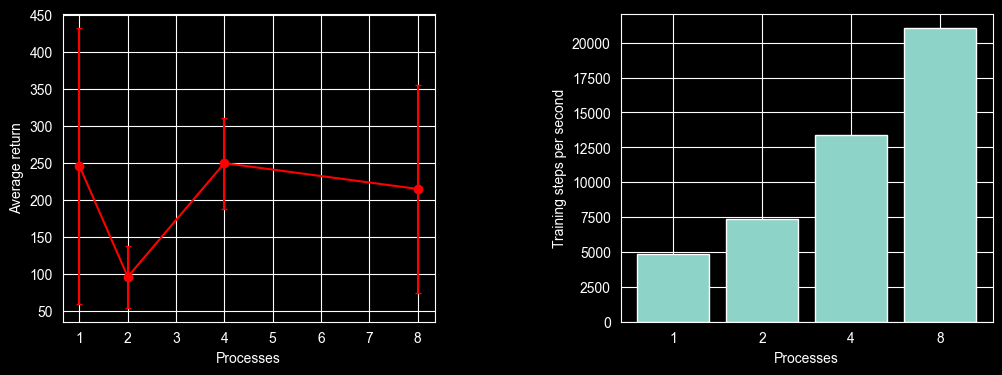

In [29]:
training_steps_per_second = [TRAIN_STEPS / t for t in training_times]
plot_training_results(training_steps_per_second, reward_averages, reward_std)

In [30]:
SECONDS_PER_EXPERIMENT = 10
steps_per_experiment = [int(SECONDS_PER_EXPERIMENT * fps) for fps in training_steps_per_second]
reward_averages = []
reward_std = []
training_times = []

for n_procs, train_steps in zip(PROCESSES_TO_TEST, steps_per_experiment):
    total_procs += n_procs
    print(f"Running for n_procs = {n_procs} for steps = {train_steps}")
    if n_procs == 1:
        # if there is only one process, there is no need to use multiprocessing
        train_env = DummyVecEnv([lambda: gym.make(env_id)])
    else:
        train_env = SubprocVecEnv([make_env(env_id, i+total_procs) for i in range(n_procs)], start_method="spawn")
        # Alternatively, you can use a DummyVecEnv if the communication delays is the bottleneck
        # train_env = DummyVecEnv([make_env(env_id, i+total_procs) for i in range(n_procs)])

    rewards = []
    times = []

    for experiment in range(NUM_EXPERIMENTS):
        # it is recommended to run several experiments due to variability in results
        train_env.reset()
        model = ALGO("MlpPolicy", train_env, verbose=0)
        start = time.time()
        model.learn(total_timesteps=train_steps)
        times.append(time.time() - start)
        mean_reward, _ = evaluate_policy(model, eval_env, n_eval_episodes=EVAL_EPS)
        rewards.append(mean_reward)

    train_env.close()
    reward_averages.append(np.mean(rewards))
    reward_std.append(np.std(rewards))
    training_times.append(np.mean(times))

Running for n_procs = 1 for steps = 48545


/Users/geraldamasi/PycharmProjects/RL/.venv/lib/python3.13/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Running for n_procs = 2 for steps = 73568
Running for n_procs = 4 for steps = 133748
Running for n_procs = 8 for steps = 210296


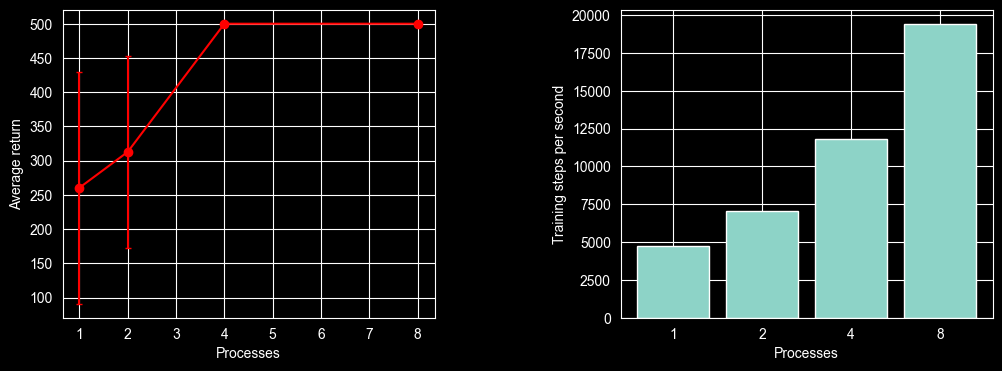

In [31]:
training_steps_per_second = [s / t for s,t in zip(steps_per_experiment, training_times)]

plot_training_results(training_steps_per_second, reward_averages, reward_std)

## Extra

In [37]:
# This is how you can train and visualize a model using SubprocVecEnv easily
env_id = 'CartPole-v1'
n_procs = 4
vec_env = SubprocVecEnv([make_env(env_id, i) for i in range(n_procs)])
model = PPO('MlpPolicy', vec_env, verbose=1).learn(total_timesteps=25_000)
obs = vec_env.reset()
for _ in range(1000):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = vec_env.step(action)
    vec_env.render()

Using cpu device
------------------------------
| time/              |       |
|    fps             | 17504 |
|    iterations      | 1     |
|    time_elapsed    | 0     |
|    total_timesteps | 8192  |
------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 9531         |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 16384        |
| train/                  |              |
|    approx_kl            | 0.0143310595 |
|    clip_fraction        | 0.231        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.681       |
|    explained_variance   | -0.00122     |
|    learning_rate        | 0.0003       |
|    loss                 | 3.31         |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.0261      |
|    value_loss           | 19.1         |
-----------------------------------